In [2]:
# Vamos a realizar una prueba solo son la prediccion de latitudes
import pandas as pd 
import numpy as np

import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau 
from tensorflow.keras.regularizers import l2
import sys
sys.path.append('../')
from Utils import utils_nn as utlnn


In [3]:
x_test = pd.read_excel("../Train_Test/Dataset_Separado/x_test_new.xlsx")
x_train = pd.read_excel("../Train_Test/Dataset_Separado/x_train_new.xlsx")
y_test = pd.read_excel("../Train_Test/Dataset_Separado/y_test_new.xlsx")
y_train = pd.read_excel("../Train_Test/Dataset_Separado/y_train_new.xlsx")

In [4]:
#Definimos el radio Ro = 6.371E6
R0= 6.371E6 # [m]

out_x_coord = [f'x_{i}' for i in range(1,101)]

y_train_x=y_train[out_x_coord]/R0
y_test_x = y_test[out_x_coord]/R0

# Nota: 'y_test_x' posee 1026 lineas con [x_1 ... x_100] columnas

In [5]:
print("Forma de x_train:", x_train.shape)

for i, col_name in enumerate(x_train.columns):
    col = x_train[col_name]
    print(f"Columna {i} ({col_name}): min={col.min():.4f}, max={col.max():.4f}, mean={col.mean():.4f}, std={col.std():.4f}")


Forma de x_train: (4104, 9)
Columna 0 (latitude_pos_tx): min=-42.2800, max=-42.2800, mean=-42.2800, std=0.0000
Columna 1 (longitude_pos_tx): min=-63.4000, max=-63.4000, mean=-63.4000, std=0.0000
Columna 2 (elevation_pos_tx): min=0.0000, max=0.0000, mean=0.0000, std=0.0000
Columna 3 (fc [Mhz]): min=3.0000, max=30.0000, mean=13.7032, std=6.9191
Columna 4 (elevation): min=0.0000, max=40.0000, mean=13.6659, std=11.8820
Columna 5 (azimuth): min=87.0000, max=98.0000, mean=92.8209, std=4.5824
Columna 6 (year): min=2010.0000, max=2010.0000, mean=2010.0000, std=0.0000
Columna 7 (mmdd): min=101.0000, max=1231.0000, mean=985.1394, std=348.8719
Columna 8 (hour): min=0.0000, max=20.0000, mean=11.1647, std=4.5880


In [6]:
x_train = x_train.drop(columns = ['latitude_pos_tx', 'longitude_pos_tx', 'elevation_pos_tx', 'year'])
x_test = x_test.drop(columns =['latitude_pos_tx', 'longitude_pos_tx', 'elevation_pos_tx', 'year'])

In [7]:
# epoch = 1200
# b_s = 70

# while epoch <= 1500:
#   while b_s <= 130:
#     l2_reg = 0.00
#     inputs = Input(shape=(9,))
#     encoded = Dense(9, activation='relu',kernel_regularizer=l2(l2_reg))(inputs)  # Compresión 8 V3 16 n 
#     encoded = Dense(16, activation='relu',kernel_regularizer=l2(l2_reg))(encoded)
#     encoded = Dense(32, activation='relu',kernel_regularizer=l2(l2_reg))(encoded)
#     encoded = Dense(64, activation = 'relu',kernel_regularizer=l2(l2_reg))(encoded)
#     encoded = Dense(80, activation = 'relu',kernel_regularizer=l2(l2_reg))(encoded)
#     encoded = Dense(90, activation = 'relu',kernel_regularizer=l2(l2_reg))(encoded)
#     decoded = Dense(100, activation='linear',kernel_regularizer=l2(l2_reg), name = 'x_output')(encoded)  # Reconstrucción a 100 puntos
#     autoencoder_x = Model(inputs, decoded)
#     autoencoder_x.compile(optimizer = 'adam', loss='mse')
#     autoencoder_x.summary()

#     history = autoencoder_x.fit(x_train,y_train_x,
#                           epochs = epoch,
#                           batch_size = b_s, 
#                           validation_split = 0.1)

#     loss = autoencoder_x.evaluate(x_test, y_test_x)
    
#     if loss <= 35:
#       autoencoder_x.save(f'../modelos_entrenamiento/modelos_x/mod_x_{epoch}_{b_s}_vs10_Adam_loss_{round(loss)}.keras')
#     print(f'Pérdida en datos de Test: {loss} epoch: {epoch}, batch_size: {b_s}')
#     b_s += 20  
#   b_s = 80
#   epoch +=40

In [8]:
from sklearn.preprocessing import MinMaxScaler

scaler_x = MinMaxScaler()

y_train_x_scaled = scaler_x.fit_transform(y_train_x)
y_test_x_scaled = scaler_x.transform(y_test_x) 

In [9]:
early_stopping = EarlyStopping(
  monitor = 'val_loss',	#monitoriamos la pérdida en validación
  patience = 30, # Si no mejora en 10->20 epochs, detenemos el entrenamiento.
  restore_best_weights = True # Restaura los mejores pesos encontrados.
)

reduce_lr = ReduceLROnPlateau(
  monitor = 'val_loss',
  patience = 20,
  factor = 0.5
)

In [ ]:
from tensorflow.keras.optimizers import Adam, AdamW, RMSprop, Nadam,SGD

#definiciones 
act_name = "relu"
l2_reg = 0.0007 #0.0001
epoch = 700
b_s = 64 
optimizer_name = Adam(learning_rate=1e-3)
# optimizer_name = RMSprop(learning_rate=1e-3)

inputs = Input(shape=(5,))
# encoded = Dense(8, activation='relu',kernel_regularizer=l2(l2_reg))(inputs)  # Compresión 8 V3 16 n 
# encoded = Dense(16, activation='relu',kernel_regularizer=l2(l2_reg))(encoded) #V3
encoded = Dense(32, activation='relu',kernel_regularizer=l2(l2_reg))(inputs)
# encoded = Dense(64, activation = 'relu',kernel_regularizer=l2(l2_reg))(encoded)
encoded = Dense(80, activation = 'relu',kernel_regularizer=l2(l2_reg))(encoded)
# encoded = Dense(90, activation = 'relu',kernel_regularizer=l2(l2_reg))(encoded)
encoded = Dense(128, activation=act_name, kernel_regularizer=l2(l2_reg))(encoded)
encoded = Dense(256, activation=act_name, kernel_regularizer=l2(l2_reg))(encoded)
decoded = Dense(100, activation='linear',kernel_regularizer=l2(l2_reg), name = 'x_output')(encoded)  # Reconstrucción a 100 puntos

# Definición del modelo
autoencoder_x = Model(inputs, decoded)
autoencoder_x.compile(optimizer = optimizer_name, loss='mae') #, metrics=['mae']
autoencoder_x.summary()

history = autoencoder_x.fit(x_train,y_train_x_scaled,
                          epochs = epoch, 
                          batch_size = b_s,
                          validation_split = 0.1,
                          callbacks=[reduce_lr]
                          )

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 5)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 32)             │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 80)             │         2,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 128)            │        10,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ x_output (Dense)                │ (None, 100)            │        25,700 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 71,924 (280.95 KB)

 Trainable params: 71,924 (280.95 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/700
58/58 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 6.1524 - val_loss: 0.4763 - learning_rate: 0.0010
Epoch 2/700
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4252 - val_loss: 0.3702 - learning_rate: 0.0010
Epoch 3/700
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3823 - val_loss: 0.2835 - learning_rate: 0.0010
Epoch 4/700
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.2832 - val_loss: 0.2976 - learning_rate: 0.0010
Epoch 5/700
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2864 - val_loss: 0.2865 - learning_rate: 0.0010
Epoch 6/700
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2739 - val_loss: 0.3041 - learning_rate: 0.0010
Epoch 7/700
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2662 - val_loss: 0.2686 - learning_rate: 0.0010
Epoch 8/700
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2502 - val_loss: 0.2378 - learning_rate: 0.0010
Epoch 9/700
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2364 - val_loss: 0.2179 - learning_rate: 0.0010
Epoch 10/700
58/58

In [42]:
loss = autoencoder_x.evaluate(x_test, y_test_x_scaled)
print(f'Pérdida en datos de Test: {loss}')

# nota: 0.00032 
# [0.003203689120709896, 0.032577596604824066]
# [0.0031841585878282785, 0.031963370740413666]
# [0.00023003153910394758, 0.008729767054319382] Esto me muestra sin L2(0.0)

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0301
Pérdida en datos de Test: 0.02991759404540062


In [57]:
idx = 1000 

# print(x_test.iloc[idx])
 # Elegir una muestra para comparar (observar luego la muestra 30)

# Predicción de una muestra 
y_pred_scaled = autoencoder_x.predict(np.expand_dims(x_test.iloc[idx], axis=0))
###############################################
y_true = y_test_x.iloc[idx].to_numpy() # Se obtine Algo de tipo Serie y se lo pasa a numpy
#Desnormalizamos 
y_pred = scaler_x.inverse_transform(y_pred_scaled)
y_pred = y_pred.flatten() # [[...,...,...,....,]]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


luego ver las graficas de la num 70

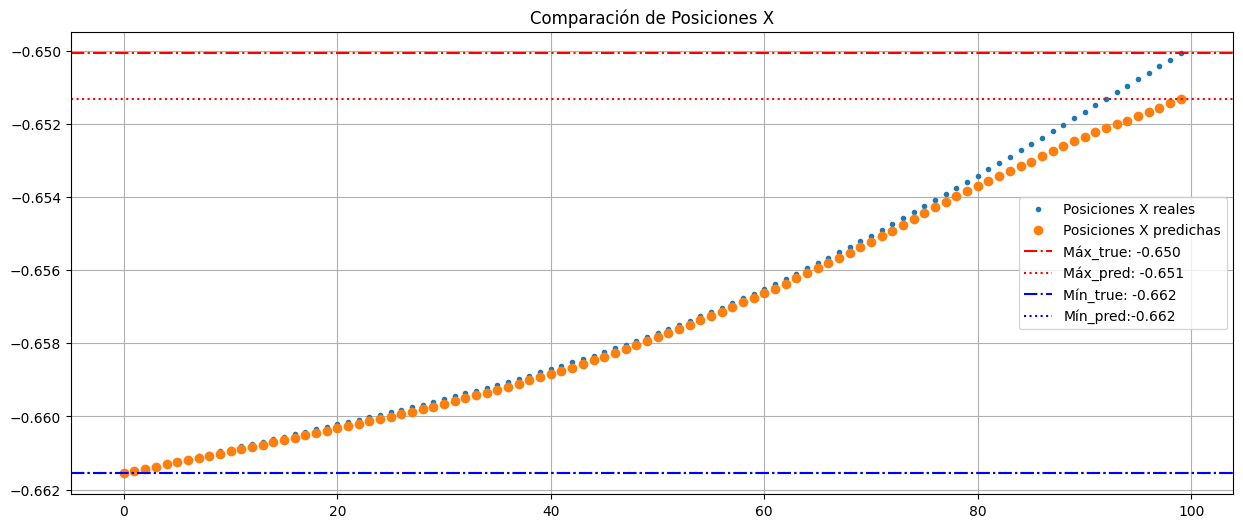

In [58]:
##Graficamos 
# Buscamos los máximos y mínimos 
y_true_max = np.max(y_true)
y_true_min = np.min(y_true)

y_pred_max = np.max(y_pred)
y_pred_min = np.min(y_pred)

# Pos x
plt.figure(figsize=(15, 6))
plt.plot(y_true, label='Posiciones X reales', linestyle='None', marker='.')
plt.plot(y_pred, label='Posiciones X predichas', linestyle = 'None',marker='o')
# Dibujamos los max y min
plt.axhline(y = y_true_max, color = 'red', linestyle = '-.', label=f'Máx_true: {y_true_max:.3f}')
plt.axhline(y = y_pred_max, color = 'red', linestyle = ':', label= f'Máx_pred: {y_pred_max:.3f}')
plt.axhline(y = y_true_min, color = 'blue', linestyle ='-.', label=f'Mín_true: {y_true_min:.3f}')
plt.axhline(y = y_pred_min, color = 'blue', linestyle = ':',label= f'Mín_pred:{y_pred_min: .3f}')

# plt.ylim(-35,-50) ##(-60,-30)
plt.title('Comparación de Posiciones X')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
save_model = False

if save_model == True:
  autoencoder_x.save('../modelos_entrenamiento/mod_x_R0/mod_x_400_32_vs10_Nadam_l2_0.keras')

In [ ]:
# Pérdida en datos de Test: 30.48688316345215  / mod_x_800_130_vs10 (Despues de 55 pasadas)
# Pérdida en datos de Test: 112.4796371459961 / mod_x_700_80_vs10
# Pérdida en datos de Test: 93.09298706054688 / mod_x_800_90_vs10
# Pérdida en datos de Test: 36.03205490112305 / mod_x_800_160_vs10_AdamW_l2_0003

In [59]:
# GUARDAR modelo
autoencoder_x.save("../modelos_entrenamiento/mod_x_R0/modelo1_x_con_scaler/modelo1_x.keras")



In [61]:
import pickle
with open("../modelos_entrenamiento/mod_x_R0/modelo1_x_con_scaler/scaler_x1.pkl","wb") as f:
	pickle.dump(scaler_x,f)